In [1]:
#import pip
#pip.main(["install", "torch"])
# pip.main(["install", "seaborn"])
import torch
from torch_geometric.datasets import TUDataset
import random
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROTEINS = torch.load("PROTEINS.pt")
PROTEINS.shape

torch.Size([1113, 2, 50, 50])

In [3]:
# Download the labels
dataset = 'PROTEINS'
graphs = TUDataset(root='/tmp/' + dataset, name=dataset)
y = [graph.y for graph in graphs]

Processing...
Done!


In [4]:
calss_0_id = np.array(y).reshape(-1)==0
PROTEINS_0 = PROTEINS[calss_0_id, :, :, :]
PROTEINS_1 = PROTEINS[~calss_0_id, :, :, :]

In [5]:
PROTEINS_list = [np.array(PROTEINS[i, :, :, :]) for i in range(PROTEINS.shape[0])]
PROTEINS_0_list = [np.array(PROTEINS_0[i, :, :, :]) for i in range(PROTEINS_0.shape[0])]
PROTEINS_1_list = [np.array(PROTEINS_1[i, :, :, :]) for i in range(PROTEINS_1.shape[0])]

In [6]:
# Determine the rank of each mode
T_list_r = PROTEINS_0_list
L = len(T_list_r)
T_list = T_list_r 
J = 3
ranks = []
for j in range(J):
    ranks_j = []
    for l in range(len(T_list)):
        Sigma_l = np.linalg.svd(tl.unfold(T_list[l], j), full_matrices=False)[1]
        ranks_j.append(np.argmax(Sigma_l[:-1] / Sigma_l[1:]) + 2)

    ranks.append(ranks_j)

In [7]:
np.mean(ranks, axis=1)

array([2.        , 3.8974359 , 3.65912519])

In [8]:
def real_data_homo(tensor_list, L_seq, test_size, rank, reps=200, seed=1):
    random.seed(seed)
    res = []
    T_list_copy = tensor_list.copy()

    for L in L_seq:
        print(f"Begin repetitions for L={L}")
        res_rep = []
        for rep in range(reps):
            random.shuffle(T_list_copy)
            T_list_test = T_list_copy[(-test_size): ]
            T_train = T_list_copy[:(-test_size)]
            T_list = random.sample(T_train, L)

            r = rank
            U_inits = [tl.decomposition.tucker(T, rank=r)[1] for T in T_list]
            J = len(T_list[0].shape)
            modes_all = list(range(J))
            U_hats = []
            for l in range(L):
                U_hat_l = []
                for j in range(J):
                    if(j!=(J-1)):
                        M = tl.unfold(tl.tenalg.multi_mode_dot(T_list[l], 
                                                [np.transpose(U) for U in (U_inits[l][:j] + U_inits[l][(j+1):])], 
                                                modes=modes_all[:j]+modes_all[(j+1): ]), j)
                    else:
                        M = tl.unfold(tl.tenalg.multi_mode_dot(T_list[l], 
                                                [np.transpose(U) for U in U_inits[l][:j]], 
                                                modes=modes_all[:j]), j)
                    
                    U_hat_jl = np.linalg.svd(M, full_matrices=False)[0][:, :r[j]]
                    
                    U_hat_l.append(U_hat_jl)

                U_hats.append(U_hat_l)

            U_estmators = []
            for j in range(J):
                U_aggregate = 0
                for l in range(L):
                    U_aggregate += U_hats[l][j] @ np.transpose(U_hats[l][j]) / L
                U_est = np.linalg.svd(U_aggregate, full_matrices=False)[0][:, :r[j]]
                U_estmators.append(U_est)

            # averaged pooled
            T_pooled = 0
            for T in T_list:
                T_pooled += (1/L) * T
            U_pooled = tl.decomposition.tucker(T_pooled, rank=r)[1]

            errors_dist = np.zeros(len(T_list_test))
            errors_single = np.zeros((len(T_list), len(T_list_test)))
            errors_pooled = np.zeros(len(T_list_test))

            for l2 in range(len(T_list_test)):
                T_hat_dist = tl.tenalg.multi_mode_dot(T_list_test[l2], [U @ np.transpose(U) for U in U_estmators], modes=list(range(J)))
                errors_dist[l2] = tl.norm(T_hat_dist - T_list_test[l2]) / tl.norm(T_list_test[l2])

                T_hat_pooled = tl.tenalg.multi_mode_dot(T_list_test[l2], [U @ np.transpose(U) for U in U_pooled], modes=list(range(J)))
                errors_pooled[l2] = tl.norm(T_hat_pooled - T_list_test[l2]) / tl.norm(T_list_test[l2])

                for l1 in range(len(T_list)):
                    T_hat_single = tl.tenalg.multi_mode_dot(T_list_test[l2], [U @ np.transpose(U) for U in U_inits[l1]], 
                                        modes=list(range(J)))
                    errors_single[l1, l2] = tl.norm(T_hat_single - T_list_test[l2]) / tl.norm(T_list_test[l2])
            
            res_rep.append([np.mean(errors_dist), np.mean(errors_single), np.mean(errors_pooled)])
    
        res_rep = np.array(res_rep)

        print(f"The reconstruction error for distributed, single, and pooled are {np.mean(res_rep, axis=0)}, respectively.")
    
        res.append(np.hstack((np.mean(res_rep, axis=0), np.std(res_rep, axis=0))))

    return(np.array(res))


In [9]:
res_large_r = real_data_homo(PROTEINS_0_list, L_seq=np.arange(1, 95, 5), test_size=100, rank=[2, 4, 4], reps=200, seed=1)
res_small_r = real_data_homo(PROTEINS_0_list, L_seq=np.arange(1, 95, 5), test_size=100, rank=[1, 2, 2], reps=200, seed=1)

Begin repetitions for L=1
The reconstruction error for distributed, single, and pooled are [0.06518047 0.06522759 0.06522759], respectively.
Begin repetitions for L=6
The reconstruction error for distributed, single, and pooled are [0.04435522 0.06247799 0.03874992], respectively.
Begin repetitions for L=11
The reconstruction error for distributed, single, and pooled are [0.04075873 0.05982645 0.03583836], respectively.
Begin repetitions for L=16
The reconstruction error for distributed, single, and pooled are [0.03976425 0.05917071 0.03392592], respectively.
Begin repetitions for L=21
The reconstruction error for distributed, single, and pooled are [0.03841383 0.05816271 0.03452718], respectively.
Begin repetitions for L=26
The reconstruction error for distributed, single, and pooled are [0.03836461 0.05973011 0.03406437], respectively.
Begin repetitions for L=31
The reconstruction error for distributed, single, and pooled are [0.03889504 0.05992414 0.03468574], respectively.
Begin re

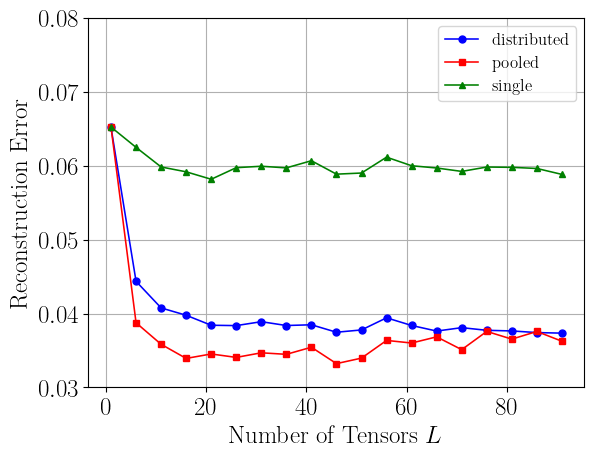

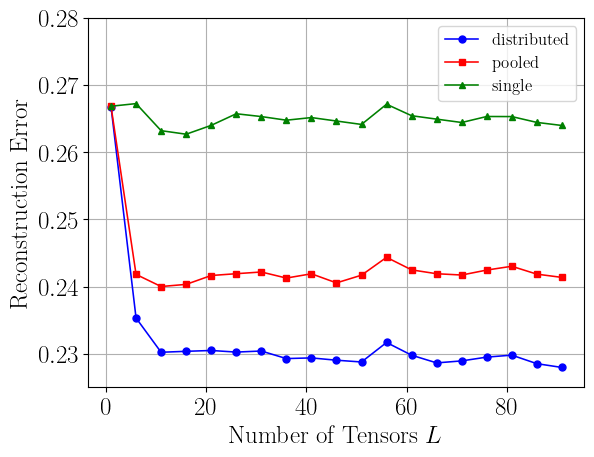

In [10]:
# Plot the results

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 18})

res = res_large_r
ms = 5
lw = 1.15
L_seq = np.arange(1, 95, 5)

plt.plot(L_seq, res[:, 0], linewidth=lw, marker='o', linestyle='-', markersize=ms, label="distributed", color="blue")
plt.plot(L_seq, res[:, 2], linewidth=lw, marker='s', linestyle='-', markersize=ms, label="pooled", color="red")
plt.plot(L_seq, res[:, 1], linewidth=lw, marker='^', linestyle='-', markersize=ms, label="single", color="green")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel("Number of Tensors $L$")
plt.ylabel("Reconstruction Error")
plt.ylim(0.03, 0.08)
plt.grid(True)
#plt.yscale("log")
plt.savefig(f"real_large_r.png", bbox_inches='tight', dpi=150)
plt.show()


res = res_small_r
ms = 5
lw = 1.15
plt.plot(L_seq, res[:, 0], linewidth=lw, marker='o', linestyle='-', markersize=ms, label="distributed", color="blue")
plt.plot(L_seq, res[:, 2], linewidth=lw, marker='s', linestyle='-', markersize=ms, label="pooled", color="red")
plt.plot(L_seq, res[:, 1], linewidth=lw, marker='^', linestyle='-', markersize=ms, label="single", color="green")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel("Number of Tensors $L$")
plt.ylabel("Reconstruction Error")
plt.ylim(0.225, 0.28)
plt.grid(True)
#plt.yscale("log")
plt.savefig(f"real_small_r.png", bbox_inches='tight', dpi=150)
plt.show()


In [11]:
# Transfer Learning
def real_data_transfer(source_list, target_list, test_size, L_seq, rU, rV, r, seed=1):
    random.seed(seed)
    res = []
    for L in L_seq:
        print(f"Begin repetitions for L={L}")
        res_rep = []
        for rep in range(200):
            random.shuffle(source_list)
            random.shuffle(target_list)
            T_train_0 = source_list[:(-test_size)]
            T_list_test = target_list[(-test_size):]
            T_train_1 = target_list[:(-test_size)]
            
            T_list_0 = random.sample(T_train_0, L)
            T_0 = 0
            for T in T_list_0:
                T_0 += (1/L) * T
        
            T_list_1 = random.sample(T_train_1, L)
            T_1 = 0
            for T in T_list_1:
                T_1 += (1/L) * T
        
            T_list = [T_0, T_1]


            UV_inits = [tl.decomposition.tucker(T, rank=r)[1] for T in T_list]

            J = len(T_list[0].shape)
            modes_all = list(range(J))
            U_hats = []
            M_list = []
            L_tasks = len(T_list)
            for l in range(L_tasks):
                U_hat_l = []
                M_list_l = []
                for j in range(J):
                    if(j!=(J-1)):
                        M = tl.unfold(tl.tenalg.multi_mode_dot(T_list[l], 
                                                [np.transpose(U) for U in (UV_inits[l][:j] + UV_inits[l][(j+1):])], 
                                                modes=modes_all[:j]+modes_all[(j+1): ]), j)
                    else:
                        M = tl.unfold(tl.tenalg.multi_mode_dot(T_list[l], 
                                                [np.transpose(U) for U in UV_inits[l][:j]], 
                                                modes=modes_all[:j]), j)
                    M_list_l.append(M)
                    U_hat_jl = np.linalg.svd(M, full_matrices=False)[0][:, :rU[j]]
                    U_hat_l.append(U_hat_jl)

                U_hats.append(U_hat_l)
                M_list.append(M_list_l)

            U_estmators = []
            for j in range(J):
                U_aggregate = 0
                sigma_hat = np.zeros(L_tasks)
                for l in range(L_tasks):
                    UUt_est = [U @ np.transpose(U) for U in U_hats[l]]
                    sigma_hat[l] = np.linalg.norm((T_list[l] - tl.tenalg.multi_mode_dot(T_list[l], UUt_est,
                                                                                    modes=modes_all)).reshape(-1)) / np.sqrt(np.prod(T_list[l].shape))
                weights = ((1/sigma_hat) ** 2) / np.sum((1/sigma_hat) ** 2)
                for l in range(L_tasks):    
                    U_aggregate += U_hats[l][j] @ np.transpose(U_hats[l][j]) * weights[l]
                U_est = np.linalg.svd(U_aggregate, full_matrices=False)[0][:, :rU[j]]
                U_estmators.append(U_est)
            
            V_estmators = []
            for l in range(L_tasks):
                V_est_l = []
                for j in range(J):
                    p_j = T_list[l].shape[j]
                    V_hat_jl = np.linalg.svd((np.diag(np.ones(p_j)) - U_estmators[j] @ np.transpose(U_estmators[j])) @ M_list[l][j], 
                                            full_matrices=False)[0][:, :rV[j]]
                    V_est_l.append(V_hat_jl)
                V_estmators.append(V_est_l)

            errors_trans = np.zeros(len(T_list_test))
            errors_non = np.zeros(len(T_list_test))

            UV_estmators = [[np.hstack((U_estmators[j], V_estmators[l][j])) for j in range(J)] for l in range(L_tasks)]

            for l in range(len(T_list_test)):

                T_hat_trans = tl.tenalg.multi_mode_dot(T_list_test[l], [U @ np.transpose(U) for U in UV_estmators[1]], modes=list(range(J)))
                errors_trans[l] = tl.norm(T_hat_trans - T_list_test[l]) / tl.norm(T_list_test[l])

                T_hat_non = tl.tenalg.multi_mode_dot(T_list_test[l], [U @ np.transpose(U) for U in UV_inits[1]], modes=list(range(J)))
                errors_non[l] = tl.norm(T_hat_non - T_list_test[l]) / tl.norm(T_list_test[l])

            res_rep.append([np.mean(errors_trans), np.mean(errors_non)])
        
        res_rep = np.array(res_rep)
        
        print(f"The reconstruction errors with transfer and without transfer are {np.mean(res_rep, axis=0)}")
        res.append(np.mean(res_rep, axis=0))
    
    return(np.array(res))


In [12]:
res_transfer_large_rU = real_data_transfer(PROTEINS_0_list, PROTEINS_1_list, test_size=100, L_seq=np.arange(1, 95, 5), rU=[1, 2, 2], rV=[1, 2, 2], r=[2, 4, 4], seed=1)
res_transfer_small_rU = real_data_transfer(PROTEINS_0_list, PROTEINS_1_list, test_size=100, L_seq=np.arange(1, 95, 5), rU=[1, 1, 1], rV=[1, 3, 3], r=[2, 4, 4], seed=1)

Begin repetitions for L=1
The reconstruction errors with transfer and without transfer are [0.1651144 0.091587 ]
Begin repetitions for L=6
The reconstruction errors with transfer and without transfer are [0.0502117  0.05290598]
Begin repetitions for L=11
The reconstruction errors with transfer and without transfer are [0.05173633 0.05506508]
Begin repetitions for L=16
The reconstruction errors with transfer and without transfer are [0.05153981 0.05675245]
Begin repetitions for L=21
The reconstruction errors with transfer and without transfer are [0.04870546 0.05454872]
Begin repetitions for L=26
The reconstruction errors with transfer and without transfer are [0.04850428 0.05555092]
Begin repetitions for L=31
The reconstruction errors with transfer and without transfer are [0.04694722 0.05468645]
Begin repetitions for L=36
The reconstruction errors with transfer and without transfer are [0.04578539 0.05641881]
Begin repetitions for L=41
The reconstruction errors with transfer and witho

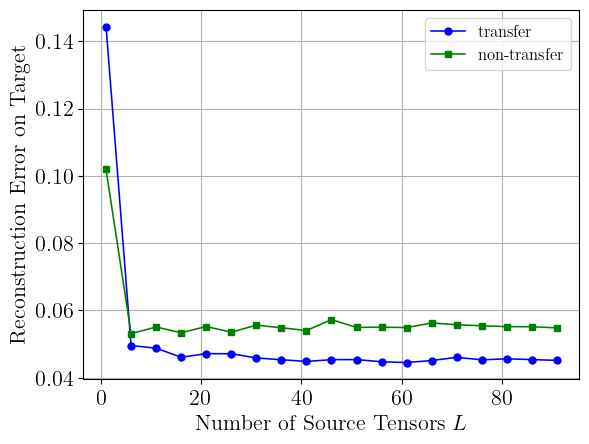

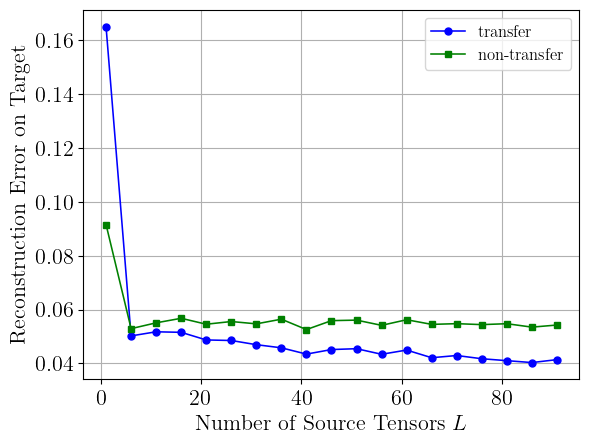

In [13]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
#res = res_small_r
ms = 5
lw = 1.15
res = res_transfer_small_rU 
L_seq = np.arange(1, 95, 5)

plt.plot(L_seq, res[:, 0], linewidth=lw, marker='o', linestyle='-', markersize=ms, label="transfer", color="blue")
plt.plot(L_seq, res[:, 1], linewidth=lw, marker='s', linestyle='-', markersize=ms, label="non-transfer", color="green")

plt.legend(loc='best', fontsize=12)
plt.xlabel("Number of Source Tensors $L$")
plt.ylabel("Reconstruction Error on Target")
# plt.ylim(0, 0.08)
plt.grid(True)
#plt.yscale("log")
plt.savefig(f"transfer_small_r.png", bbox_inches='tight', dpi=150)
plt.show()

res = res_transfer_large_rU 
L_seq = np.arange(1, 95, 5)

plt.plot(L_seq, res[:, 0], linewidth=lw, marker='o', linestyle='-', markersize=ms, label="transfer", color="blue")
plt.plot(L_seq, res[:, 1], linewidth=lw, marker='s', linestyle='-', markersize=ms, label="non-transfer", color="green")

plt.legend(loc='best', fontsize=12)
plt.xlabel("Number of Source Tensors $L$")
plt.ylabel("Reconstruction Error on Target")
# plt.ylim(0, 0.08)
plt.grid(True)
#plt.yscale("log")
plt.savefig(f"transfer_large_r.png", bbox_inches='tight', dpi=150)
plt.show()